In [2]:
%%capture 
!python3 -m pip install google.cloud
!python3 -m pip install pandas
!python3 -m pip install numpy
!python3 -m pip install pyarrow

In [3]:
%%capture 
!python3 -m pip install statsmodels

In [4]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
magics.context.use_bqstorage_api = True
import pyarrow
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

In [5]:
import random

In [6]:
# CONFIGURE THE BIGQUERY SETTINGS

BIGQUERY_PROJECT = 'ironhacks-covid19-data'
BIGQUERY_KEYPATH = 'service-account.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

## Data Exploring

In [11]:
query = """
SELECT *
FROM ironhacks_covid19_competition.mobility_graph
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()
df.to_csv('mobility_graph.csv', index=False)
# df.plot('week_number','cases')

In [7]:
df

,week_number,start_date,county,fips,cases,deaths
0,11,2020-03-16,Tippecanoe,18157,7,0
1,12,2020-03-23,Tippecanoe,18157,46,3
2,13,2020-03-30,Tippecanoe,18157,148,7
3,14,2020-04-06,Tippecanoe,18157,278,7
4,15,2020-04-13,Tippecanoe,18157,352,12
5,16,2020-04-20,Tippecanoe,18157,448,14
6,17,2020-04-27,Tippecanoe,18157,790,14
7,18,2020-05-04,Tippecanoe,18157,1442,14
8,19,2020-05-11,Tippecanoe,18157,1903,14
9,20,2020-05-18,Tippecanoe,18157,2379,19


The graph above is the number of covid cases for each week, it has a logrithmic shape.

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


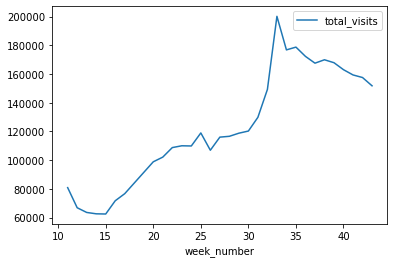

In [5]:
query = """
SELECT sum(raw_visit_counts) AS total_visits, week_number
FROM ironhacks_covid19_competition.weekly_patterns
GROUP BY week_number
ORDER BY week_number
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()
df.plot('week_number', 'total_visits')

The graph above is a graph for number of total visits to all places for each week

In [ ]:
query = """
SELECT NAICS, location_name
FROM ironhacks_covid19_competition.weekly_patterns
WHERE NAICS IS NULL
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()
print(df.count())
df = df[df['location_name'].str.contains('Auto')]
print(df.count())

I will be looking at the top categories that people visit most often

In [115]:
query = """
SELECT top_category,
COUNT(top_category) AS occurrence
FROM ironhacks_covid19_competition.weekly_patterns
GROUP BY top_category
ORDER BY occurrence DESC
LIMIT 12
"""

query_job = bigquery_client.query(query)
top_cat = query_job.to_dataframe()
# top_cat

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


I will be looking at the shape of the disctribution for the visitors of the top 10 categories

In [9]:
query = """
SELECT *
FROM ironhacks_covid19_competition.weekly_patterns
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()
cat = df[df['top_category'].isin(top_cat['top_category'])]

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


NameError: name 'top_cat' is not defined

In [139]:
df[df['poi_id'].isin(['322265e6-5192-435d-b982-e25f5c1310f6','55ef29c0-bef9-4848-97da-78d5d85a9a7a'])]


,poi_id,location_name,latitude,longitude,city,postal_code,brands,top_category,NAICS,week_number,date_start,raw_visit_counts,visits_concentration,poi_cbg,distance_from_home,median_dwell
635,55ef29c0-bef9-4848-97da-78d5d85a9a7a,Purdue University,40.429448,-86.921226,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,11,2020-03-16,92,196.12,181570055001,11137.0,71.0
638,322265e6-5192-435d-b982-e25f5c1310f6,Purdue University Main Campus,40.423823,-86.924163,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,11,2020-03-16,368,164.22,181570054003,7648.0,114.5
2234,55ef29c0-bef9-4848-97da-78d5d85a9a7a,Purdue University,40.429448,-86.921226,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,12,2020-03-23,89,253.76,181570055001,13435.0,56.0
2237,322265e6-5192-435d-b982-e25f5c1310f6,Purdue University Main Campus,40.423823,-86.924163,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,12,2020-03-23,323,125.09,181570054003,7440.0,100.0
3816,55ef29c0-bef9-4848-97da-78d5d85a9a7a,Purdue University,40.429448,-86.921226,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,13,2020-03-30,65,272.19,181570055001,10530.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47041,55ef29c0-bef9-4848-97da-78d5d85a9a7a,Purdue University,40.429448,-86.921226,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,41,2020-10-12,2414,94.08,181570104001,1038.0,47.0
48844,322265e6-5192-435d-b982-e25f5c1310f6,Purdue University Main Campus,40.423823,-86.924163,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,42,2020-10-19,3597,96.12,181570105001,2337.0,60.0
48845,55ef29c0-bef9-4848-97da-78d5d85a9a7a,Purdue University,40.429448,-86.921226,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,42,2020-10-19,2318,90.75,181570104001,1106.0,50.0
50648,322265e6-5192-435d-b982-e25f5c1310f6,Purdue University Main Campus,40.423823,-86.924163,West Lafayette,47907,None,"Colleges, Universities, and Professional Schools",611310.0,43,2020-10-26,3357,105.32,181570105001,1624.0,68.0


In [69]:
print(df['top_category'].nunique())

104


## Discovery:
From the graph we can see that there is a huge change for most of the categories at week 33 due to class starts at Purdue, so I will be using data from week 33 to 43 to predict week 44.

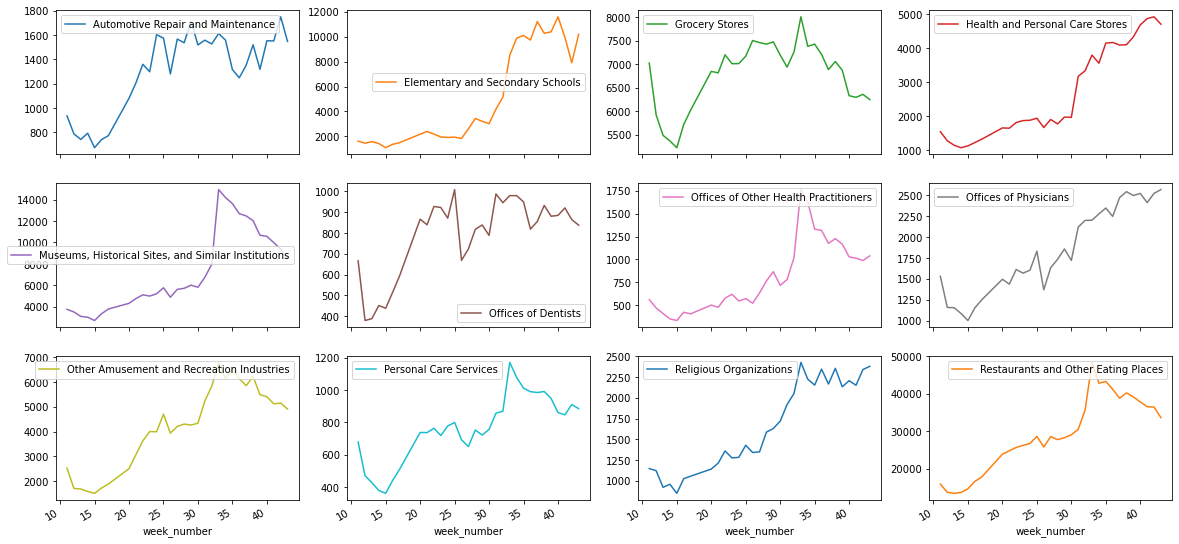

In [117]:
c = cat.groupby(['top_category', 'week_number'])['raw_visit_counts'].sum().unstack('top_category').plot(figsize=(20, 10), subplots = True, layout=(3,4))

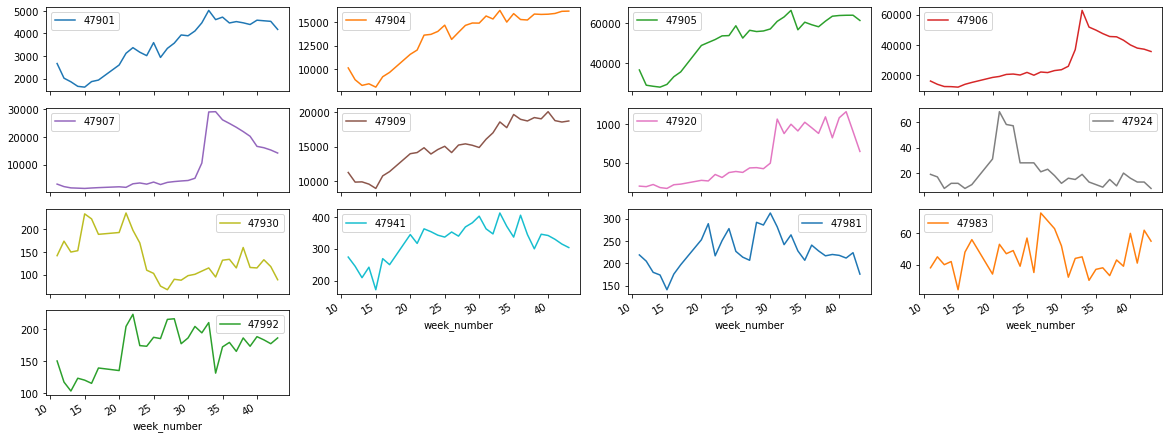

In [119]:
p = df.groupby(['postal_code', 'week_number'])['raw_visit_counts'].sum().unstack('postal_code').plot(figsize=(20, 10), subplots = True, layout=(5,4))

In [93]:
query = """
SELECT week_number, name_exec_order, no_exec_order, link
FROM ironhacks_covid19_competition.executive_orders
where exec_order_exist = 'Yes'
"""

query_job = bigquery_client.query(query)
ex = query_job.to_dataframe()
# ex

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [285]:
pd.set_option('display.max_colwidth', -1)
ex

for index, row in ex.iterrows():
    week = row[0]
    name = ast.literal_eval(row[1])
    no = ast.literal_eval(row[2])
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Prediction
Whith Linear Regression


In [120]:
query = """
    select poi_id, week_number, raw_visit_counts
    from ironhacks_covid19_competition.weekly_patterns
    order by poi_id
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()
df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,poi_id,week_number,raw_visit_counts
0,00243ce2-6ecc-4c63-8d58-1138476289e4,11,13
1,00243ce2-6ecc-4c63-8d58-1138476289e4,12,11
2,00243ce2-6ecc-4c63-8d58-1138476289e4,13,5
3,00243ce2-6ecc-4c63-8d58-1138476289e4,14,5
4,00243ce2-6ecc-4c63-8d58-1138476289e4,15,5


In [17]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params


#This is what you need
w=df.groupby('poi_id').apply(regress, 'raw_visit_counts', ['week_number'])
w['poi_id'] = w.index
w.reset_index(drop=True, inplace=True)
w['raw_visit_counts'] = w.week_number * 44 + w.intercept

In [22]:
for index, row in w.iterrows():
    if row[3] < 0:
        w['raw_visit_counts'][index] = 5

w.raw_visit_counts = w.raw_visit_counts.round()
del w["week_number"]
del w["intercept"]


poi_id              00243ce2-6ecc-4c63-8d58-1138476289e400251e06-3...
raw_visit_counts                                               150969
dtype: object

In [23]:
# write to csv
w.to_csv('prediction.csv',index=False)

## Prediction
With Vector Autoregression

In [190]:
table = pd.pivot_table(df, values='raw_visit_counts', index='week_number', columns="poi_id", fill_value=0)
table = table.replace(0,1).dropna()
# table.iloc[:, 0]

In [189]:
data = np.log(table).diff().dropna()
# data

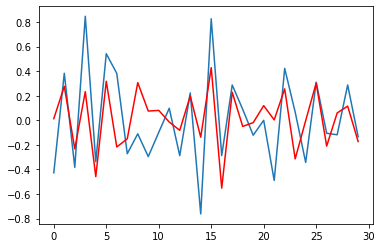

In [186]:
# model = VAR(data)
# results = model.fit(3)
# results.summary()
# model_list = df['poi_id']
# stepwise_model = auto_arima(table, start_p=1, start_q=1,
#                            max_p=3, max_q=3, m=12,
#                            start_P=0, seasonal=True,
#                            d=1, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
d = data['6a2d40f8-c477-49b6-a5d5-69c31f001afc']
d = np.array(d)
model = ARIMA(d, order=(1,0,2))
results_AR = model.fit(disp=-1)
plt.plot(d)
plt.plot(results_AR.fittedvalues, color='red')
# print('RSS: %.4f'%(results_AR.fittedvalues*(44-11)-sum(data.iloc[:, 0]**2)))
# print(data.iloc[:, 0]**2)

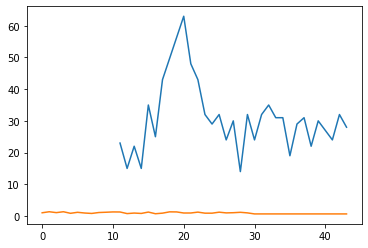

In [187]:
prediction_diff = pd.Series(results_AR.fittedvalues, copy=True)
prediction_log = pd.Series(d[0], index = data.index).add(prediction_diff.cumsum(), fill_value=0)
prediction_AR = np.exp(prediction_log)
plt.plot(table['6a2d40f8-c477-49b6-a5d5-69c31f001afc'])
plt.plot(prediction_AR)

In [52]:
query = """
SELECT poi_id, top_category, week_number, raw_visit_counts
FROM ironhacks_covid19_competition.weekly_patterns
"""
query_job = bigquery_client.query(query)
wp = query_job.to_dataframe()


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [55]:
#randomly select 100 poi_id
uniq_poi = wp['poi_id'].unique()
rand_poi = random.sample(uniq_poi.tolist(), 200)


print("unique categories: ")
print(filt_wp['top_category'].nunique())

dummy = pd.get_dummies(wp['top_category'])
table = wp.join(dummy)
dummy = pd.get_dummies(wp['poi_id'])
table = table.join(dummy)
del table['top_category']
del table['poi_id']


unique categories: 
29


,week_number,raw_visit_counts,"Accounting, Tax Preparation, Bookkeeping, and Payroll Services",Activities Related to Credit Intermediation,Administration of Economic Programs,"Agencies, Brokerages, and Other Insurance Related Activities",Amusement Parks and Arcades,Automobile Dealers,Automotive Equipment Rental and Leasing,"Automotive Parts, Accessories, and Tire Stores",...,fe190b44-532c-4f05-bd5e-64a819f37987,fe227e74-6422-4564-9c10-470fd26b9d6c,fe52a09d-6b37-4f62-8613-bc1c0eda7b55,feb97e54-f336-4440-9ea0-0b29ef024142,fef4f7b8-aba7-4740-ad71-6af091dd071c,ff017941-e5c5-4c3e-ad8e-51bee7a0d3f3,ff047527-176f-4d9b-9d91-0d0ab8805a44,ffa5b55e-5f61-4cd7-8f66-741f492c34c6,ffdda836-f200-470e-9e9d-c8917a164043,fffcc243-6692-466d-a427-4696a2f7ab61
0,11,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51726,43,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51727,43,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51728,43,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51729,43,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
#add excecutive order
# table.to_csv('pivot_table.csv',index=False)

In [73]:
filt_wp = wp[wp['week_number'] == 43]
dummy = pd.get_dummies(filt_wp['top_category'])
table = filt_wp.join(dummy)
dummy = pd.get_dummies(filt_wp['poi_id'])
table = table.join(dummy)
del table['top_category']
del table['raw_visit_counts']
table = table.replace(43, 44)
table

,poi_id,week_number,"Accounting, Tax Preparation, Bookkeeping, and Payroll Services",Activities Related to Credit Intermediation,Administration of Economic Programs,"Agencies, Brokerages, and Other Insurance Related Activities",Amusement Parks and Arcades,Automobile Dealers,Automotive Equipment Rental and Leasing,"Automotive Parts, Accessories, and Tire Stores",...,fe190b44-532c-4f05-bd5e-64a819f37987,fe227e74-6422-4564-9c10-470fd26b9d6c,fe52a09d-6b37-4f62-8613-bc1c0eda7b55,feb97e54-f336-4440-9ea0-0b29ef024142,fef4f7b8-aba7-4740-ad71-6af091dd071c,ff017941-e5c5-4c3e-ad8e-51bee7a0d3f3,ff047527-176f-4d9b-9d91-0d0ab8805a44,ffa5b55e-5f61-4cd7-8f66-741f492c34c6,ffdda836-f200-470e-9e9d-c8917a164043,fffcc243-6692-466d-a427-4696a2f7ab61
49927,6a2d40f8-c477-49b6-a5d5-69c31f001afc,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49928,49636347-5a9d-4bf3-9d9a-c21a4ba7d8f1,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49929,d98b37cd-ed64-456c-b580-c2c299c9f6d6,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49930,efb4f5e7-28c2-47be-9d47-254280b8458e,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49931,16f4e696-2065-4854-8ba6-a8cab2b67bf7,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51726,63db266e-e81c-4c87-88fe-627787e746c5,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51727,50c0e1b7-fca7-42c7-9a03-ae365b04a85f,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51728,4fd58993-41ea-4db9-9a23-fa044395d052,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51729,ddfdb9d2-0f5a-46d8-8996-c437332d96a5,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
table.to_csv('predicting_table.csv', index=False)

In [8]:
df1 = pd.read_csv("Predictions/MA3_prediction.csv")
df2= pd.read_csv("Predictions/Random Forest.csv") 
df3 = pd.read_csv("Predictions/prediction3.csv")

df1 = df1.merge(df2, on = 'poi_id')
df1 = df1.merge(df3, on = 'poi_id')


df1.columns = ['poi_id','MA3', 'random forest', 'decision tree']
df1['avg'] = (df1['MA3'] + df1['random forest'])/2

### Difference Between Models

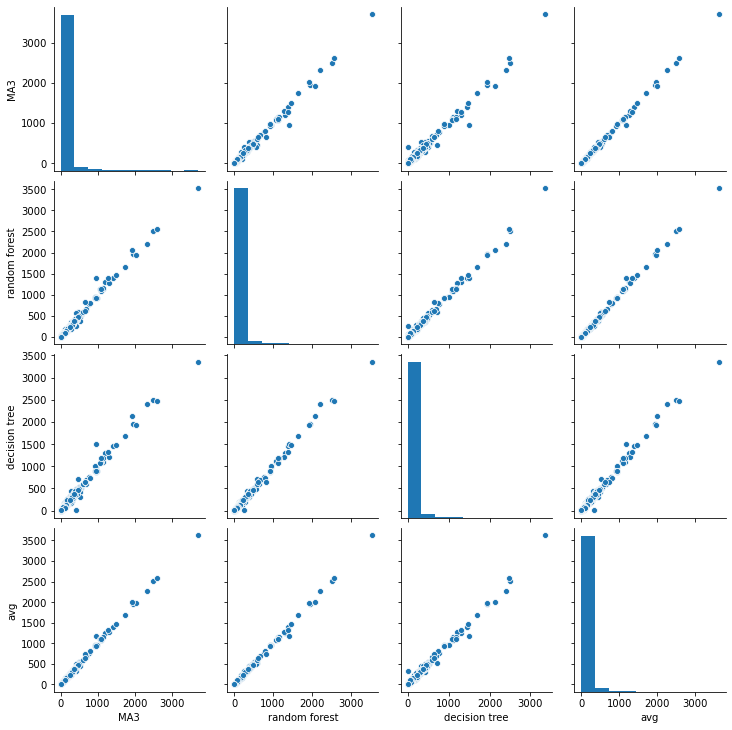

In [9]:
import seaborn as sns
# sns.set_theme(style="ticks")
sns.pairplot(df1)

In [10]:
del df1['MA3']
del df1['random forest']
del df1['decision tree']

In [11]:
df1.to_csv('avg.csv',index=False)